# Deep learning: singleton classification in XRENNER


In [1]:
cd ~/Desktop/deep_xrenner/

/Users/zangsir/Desktop/deep_xrenner


In [3]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

want: in the notMNIST data set like this:

Training set (200000, 28, 28) (200000,)

Validation set (10000, 28, 28) (10000,)

Test set (10000, 28, 28) (10000,)

and after transformation:

Training set (200000, 784) (200000, 10)

Validation set (10000, 784) (10000, 10)

Test set (10000, 784) (10000, 10)

## load data

In [ ]:
import re
#these functions are called by load_data in the case of there are a few nominal columns in the beginning of the data
def get_num_features(line):
    pat='(,\d+,\d+,\d+,\d+,\d+,)+'
    match=re.search(pat,line)
    if match:
        return match.start()
    
def strip_first_col(fname):
    with open(fname, 'r') as fin:
        next(fin)
        for line in fin:
            #print (line)
            try:
                #print (line[get_num_features(line)+1:])
                yield line[get_num_features(line)+1:]
            except IndexError:
                continue

#data = np.loadtxt(strip_first_col(datafile),skiprows=1,delimiter=',')

In [152]:
def load_data(datafile,header=True):
    if header==True:
        data = np.loadtxt(strip_first_col(datafile),skiprows=1,delimiter=',')
    else:
        data = np.loadtxt(datafile, delimiter=',',skiprows=1)

    # first ten values are the one hot encoded y (target) values
    ####y = data[:, 0:10]
    y = data[:, -1]
    # y[y == 0] = -1 # if you are using a tanh transfer function make the 0 into -1
    # y[y == 1] = .90 # try values that won't saturate tanh
    
    #if data contains header row or not
    #you also need to change col selection if your data contains nominal values
    #if header==True:
        #data = data[1:, 3:-1]
    #if header==False:
    data = data[:, :-1]  # x data
    # data = data - data.mean(axis = 1)
    data -= data.min()  # scale the data so values are between 0 and 1
    data /= data.max()  # scale
    out = []
    labels=[]
    print(data.shape)
    label_dict={1:[0,1],0:[1,0]}
    # populate the tuple list with the data
    for i in range(data.shape[0]):
        fart = list((data[i, :].tolist()))  # don't mind this variable name
        out.append(fart)
        #two classes one hot coding:two classes are [NS,S] y=1:[0,1]; y=0:[1,0]
        labels.append(label_dict[y[i]])

    return np.array(out,dtype=np.float32),np.array(labels,dtype=np.float32)

In [153]:
datafile='Data/singleton_data_new.tab'
X,labels = load_data(datafile)


(350845, 13)


In [154]:
X.shape

(350845, 13)

In [101]:
X

array([[  6.71140943e-03,   2.68456377e-02,   0.00000000e+00, ...,
          0.00000000e+00,   6.10128103e-04,   1.13177221e-05],
       [  1.34228189e-02,   6.71140943e-03,   6.71140943e-03, ...,
          0.00000000e+00,   1.22025621e-03,   2.26354441e-05],
       [  6.71140943e-03,   1.34228189e-02,   0.00000000e+00, ...,
          0.00000000e+00,   2.44051241e-03,   4.52708882e-05],
       ..., 
       [  6.71140943e-03,   2.68456377e-02,   0.00000000e+00, ...,
          0.00000000e+00,   4.72849282e-03,   2.08693999e-03],
       [  1.94630876e-01,   2.01342274e-02,   6.71140943e-03, ...,
          0.00000000e+00,   4.88102483e-03,   2.11065519e-03],
       [  5.36912754e-02,   1.34228189e-02,   1.34228189e-02, ...,
          0.00000000e+00,   5.79621736e-03,   2.25294661e-03]], dtype=float32)

In [32]:
labels

array([[0, 1],
       [0, 1],
       [1, 0],
       ..., 
       [0, 1],
       [0, 1],
       [0, 1]])

## divide into dev, val, test sets

In [111]:
train_prop=0.9
val_prop=0.05
test_prop=0.05

train_size=X.shape[0]*train_prop
val_size=X.shape[0]*val_prop
test_size=X.shape[0]*test_prop

#should shuffle the dataset

In [50]:
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels

In [113]:
#pipeline
#load data
datafile='Data/singleton_data_mini.tab'
X,labels = load_data(datafile)

#shuffle dataset
dataset_shf,labels_shf = randomize(X, labels)

#get sizes of division
train_dataset=dataset_shf[:int(train_size),:]
valid_dataset=dataset_shf[int(train_size):int(train_size+val_size),:]
test_dataset=dataset_shf[int(train_size+val_size):,:]
train_labels=labels_shf[:int(train_size)]
valid_labels=labels_shf[int(train_size):int(train_size+val_size)]
test_labels=labels_shf[int(train_size+val_size):]

#divide the dataset
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

In [115]:
train_dataset

array([[ 0.02684564,  0.00671141,  0.        , ...,  0.        ,
         0.00503356,  0.00433419],
       [ 0.00671141,  0.02684564,  0.        , ...,  0.        ,
         0.0059657 ,  0.00409857],
       [ 0.06711409,  0.02013423,  0.        , ...,  0.        ,
         0.00198292,  0.00483374],
       ..., 
       [ 0.01342282,  0.01342282,  0.        , ...,  0.        ,
         0.00491079,  0.00612212],
       [ 0.02013423,  0.02013423,  0.        , ...,  0.        ,
         0.00233882,  0.00421499],
       [ 0.06040268,  0.02013423,  0.00671141, ...,  0.        ,
         0.00457596,  0.00025422]], dtype=float32)

In [106]:
print (train_dataset.shape,train_labels.shape)
print (valid_dataset.shape,valid_labels.shape)
print (test_dataset.shape,test_labels.shape)

(36000, 14) (36000, 2)
(2000, 14) (2000, 2)
(2000, 14) (2000, 2)


In [87]:
#wrote a function to return all the singleton indexes, but accidentlly deleted that. 

In [116]:
#check if the labels are still good after shuffling
#it is good. 
print (train_dataset[12],train_labels[12])
print (train_dataset[39],train_labels[39])
print (train_dataset[10001],train_labels[10001])

[ 0.00671141  0.02684564  0.          0.          0.          0.          0.
  0.          0.00671141  0.          0.          0.          0.00494525
  0.00033726] [ 0.  1.]
[ 0.01342282  0.02013423  0.00671141  0.          0.          0.          0.
  0.00671141  0.          0.          0.          0.          0.00064533
  0.00386733] [ 0.  1.]
[ 0.02684564  0.02013423  0.00671141  0.          0.          0.          0.
  0.          0.00671141  0.          0.          0.          0.00366077
  0.00437005] [ 0.  1.]


In [117]:
train_dataset

array([[ 0.02684564,  0.00671141,  0.        , ...,  0.        ,
         0.00503356,  0.00433419],
       [ 0.00671141,  0.02684564,  0.        , ...,  0.        ,
         0.0059657 ,  0.00409857],
       [ 0.06711409,  0.02013423,  0.        , ...,  0.        ,
         0.00198292,  0.00483374],
       ..., 
       [ 0.01342282,  0.01342282,  0.        , ...,  0.        ,
         0.00491079,  0.00612212],
       [ 0.02013423,  0.02013423,  0.        , ...,  0.        ,
         0.00233882,  0.00421499],
       [ 0.06040268,  0.02013423,  0.00671141, ...,  0.        ,
         0.00457596,  0.00025422]], dtype=float32)

In [118]:
num_nodes= 1024
batch_size = 128
input_size=X.shape[1]
num_labels=2

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                      shape=(batch_size, input_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    weights_1 = tf.Variable(
      tf.truncated_normal([input_size, num_nodes]))
    biases_1 = tf.Variable(tf.zeros([num_nodes]))
    weights_2 = tf.Variable(
      tf.truncated_normal([num_nodes, num_labels]))
    biases_2 = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    relu_layer=tf.nn.relu(tf.matmul(tf_train_dataset, weights_1) + biases_1)#notice the shape of tf_train_dataset and weights_1
    logits = tf.matmul(relu_layer, weights_2) + biases_2
    loss = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(
     tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, weights_1) + biases_1), weights_2) + biases_2)
    test_prediction =  tf.nn.softmax(
     tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, weights_1) + biases_1), weights_2) + biases_2)

In [120]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [278]:
np.argmax(predictions[11]

1

In [313]:
#precision=TP/(TP+FP)
#recall=TP/(TP+FN)

#TP+FP=
predicted_sgt=np.sum(np.argmax(predictions,1)==0)
print (predicted_sgt)
real_sgt=np.sum(np.argmax(batch_labels,1)==0)
print (real_sgt)

347
424


In [331]:
precision_recall(predictions,batch_labels)

0.40625 1.0


(0.40625, 1.0, 0.5777777777777777)

In [121]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 0.576419
Minibatch accuracy: 77.3%
Validation accuracy: 86.7%
Minibatch loss at step 500: 0.303830
Minibatch accuracy: 89.8%
Validation accuracy: 86.7%
Minibatch loss at step 1000: 0.433002
Minibatch accuracy: 83.6%
Validation accuracy: 86.7%
Minibatch loss at step 1500: 0.393721
Minibatch accuracy: 86.7%
Validation accuracy: 86.7%
Minibatch loss at step 2000: 0.296616
Minibatch accuracy: 89.8%
Validation accuracy: 86.7%
Minibatch loss at step 2500: 0.398171
Minibatch accuracy: 86.7%
Validation accuracy: 86.7%
Minibatch loss at step 3000: 0.321350
Minibatch accuracy: 89.8%
Validation accuracy: 86.7%
Test accuracy: 85.0%


In [218]:
def get_singleton(labels):
    inds_notsgt=[]
    inds_sgtn=[]
    for i in range(len(labels)):
        if labels[i][0]==1:
            inds_sgtn.append(i)
        else:
            inds_notsgt.append(i)
    return inds_notsgt,inds_sgtn

In [326]:
c,ind=get_singleton(valid_labels)

In [328]:
len(c)

4951

In [163]:
float(c)/len(labels)#ratio of singleton class

0.18648764977854296

In [164]:
len(ind)

67157

In [201]:
c

67157

<h1 style='background:blue;color:white;'>data process pipeline using tensorflow</h1>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

In [3]:
def load_data(datafile):
    data = np.loadtxt(datafile, delimiter=',')

    # first ten values are the one hot encoded y (target) values
    ####y = data[:, 0:10]
    y = data[:, -1]
    # y[y == 0] = -1 # if you are using a tanh transfer function make the 0 into -1
    # y[y == 1] = .90 # try values that won't saturate tanh

    data = data[:, :-1]  # x data
    # data = data - data.mean(axis = 1)
    data -= data.min()  # scale the data so values are between 0 and 1
    data /= data.max()  # scale
    out = []
    labels=[]
    print(data.shape)
    label_dict={1:[0,1],0:[1,0]}
    # populate the tuple list with the data
    for i in range(data.shape[0]):
        fart = list((data[i, :].tolist()))  # don't mind this variable name
        out.append(fart)
        #two classes one hot coding:two classes are [NS,S] y=1:[0,1]; y=0:[1,0]
        labels.append(label_dict[y[i]])

    return np.array(out,dtype=np.float32),np.array(labels,dtype=np.float32)

In [5]:
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels

In [7]:
train_prop=0.9
val_prop=0.05
test_prop=0.05

train_size=X.shape[0]*train_prop
val_size=X.shape[0]*val_prop
test_size=X.shape[0]*test_prop

In [8]:
#pipeline
#load data
#datafile='Data/singleton_data_mini.tab'

datafile='Data/singleton_data.tab'
X,labels = load_data(datafile)

#shuffle dataset
dataset_shf,labels_shf = randomize(X, labels)

#get sizes of division
train_dataset=dataset_shf[:int(train_size),:]
valid_dataset=dataset_shf[int(train_size):int(train_size+val_size),:]
test_dataset=dataset_shf[int(train_size+val_size):,:]
train_labels=labels_shf[:int(train_size)]
valid_labels=labels_shf[int(train_size):int(train_size+val_size)]
test_labels=labels_shf[int(train_size+val_size):]

#divide the dataset
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

(360115, 12)


In [200]:
#set of a tf graph

num_nodes= 1
batch_size = 1024
input_size=X.shape[1]#dimension of each input vector
num_labels=2

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                      shape=(batch_size, input_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    weights_1 = tf.Variable(
      tf.truncated_normal([input_size, num_nodes]))
    biases_1 = tf.Variable(tf.zeros([num_nodes]))
    weights_2 = tf.Variable(
      tf.truncated_normal([num_nodes, num_labels]))
    biases_2 = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    relu_layer=tf.nn.relu(tf.matmul(tf_train_dataset, weights_1) + biases_1)#notice the shape of tf_train_dataset and weights_1
    logits = tf.matmul(relu_layer, weights_2) + biases_2
    loss = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(
     tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, weights_1) + biases_1), weights_2) + biases_2)
    test_prediction =  tf.nn.softmax(
     tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, weights_1) + biases_1), weights_2) + biases_2)


    num_steps = 6000
    train_acc=[]
    valid_acc=[]
    with tf.Session(graph=graph) as session:
        tf.initialize_all_variables().run()
        print("Initialized")
        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
            _, l, predictions = session.run(
              [optimizer, loss, train_prediction], feed_dict=feed_dict)
            if (step % 500 == 0):
                print("Minibatch loss at step %d: %f" % (step, l))
                print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
                print("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), valid_labels))
                train_acc.append(accuracy(predictions, batch_labels))
                valid_acc.append(accuracy(
                valid_prediction.eval(), valid_labels))
        print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))


Initialized
Minibatch loss at step 0: 0.697906
Minibatch accuracy: 34.2%
Validation accuracy: 82.2%
Minibatch loss at step 500: 0.488197
Minibatch accuracy: 80.8%
Validation accuracy: 82.3%
Minibatch loss at step 1000: 0.466557
Minibatch accuracy: 82.2%
Validation accuracy: 82.3%
Minibatch loss at step 1500: 0.473457
Minibatch accuracy: 81.7%
Validation accuracy: 82.3%
Minibatch loss at step 2000: 0.472589
Minibatch accuracy: 81.8%
Validation accuracy: 82.3%
Minibatch loss at step 2500: 0.511490
Minibatch accuracy: 79.1%
Validation accuracy: 82.3%
Minibatch loss at step 3000: 0.477617
Minibatch accuracy: 81.3%
Validation accuracy: 82.3%
Minibatch loss at step 3500: 0.434291
Minibatch accuracy: 84.4%
Validation accuracy: 82.3%
Minibatch loss at step 4000: 0.514738
Minibatch accuracy: 79.0%
Validation accuracy: 82.3%
Minibatch loss at step 4500: 0.443015
Minibatch accuracy: 83.7%
Validation accuracy: 82.3%
Minibatch loss at step 5000: 0.478120
Minibatch accuracy: 81.4%
Validation accurac

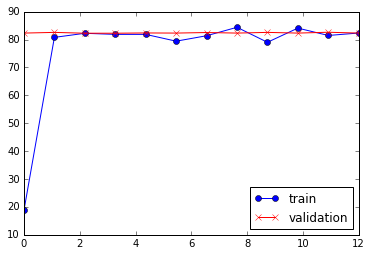

In [198]:
plot_tf()

#### comments & questions

-----
1. due to minibatch stochastic GD, the loss is not monotonically decreasing, and accuracy is not monotonically increasing. 
2. perhaps due to the nature of the dataset, the validation accuracy tend to be stuck at a constant for many steps. 
3. this is binary classification, but the class are imbalanced, so we should compute precision, recall, and F1 score.
4. num_steps, batch size, learning rate, num_nodes, so far I didn't observe a effect of changing these (hyper) parameters.
5. one observation is that validation accuracy is high on the first run. That might be due to the class imbalance. 

Questions

5. would using classic GD on all of dataset make a difference?
6. how to choose num_nodes?
7. does the class being binary (and imbalanced) make a difference than when we were doing the 10-class classification on the notMNIST dataset?


# log

## mini-dataset

## entire data set 

actually, the imbalance of the classes is a problem in this case since the mini batch is likely to get not much of the rare class. 

<h1 style='background:blue;color:white;'>Trying to construct a balanced subset and see what happens</h1>
also, implement precision and recall

In [21]:
### there are a couple functions at the previous blue title that needs to be run before this

In [10]:
def get_singleton(labels):
    inds_notsgt=[]
    inds_sgtn=[]
    for i in range(len(labels)):
        if labels[i][0]==1:
            inds_sgtn.append(i)
        else:
            inds_notsgt.append(i)
    return inds_notsgt,inds_sgtn

In [17]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [ ]:
#http://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/
#some tactics to overcome the imbalanced class problem. including resampling (oversample, undersample)

### undersamping

load data

In [110]:
#pipeline
#load data with no header and no nominal attributes
#datafile='Data/singleton_data_mini.tab'
#X,labels = load_data(datafile,header=False)

#load new data with header row and nominal attributes in the first 3 cols
datafile='Data/singleton_data_new.tab'
X,labels = load_data(datafile)

#shuffle dataset
dataset_shf,labels_shf = randomize(X, labels)

(350844, 10)


In [113]:
labels

array([[ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.],
       ..., 
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.]], dtype=float32)

sample singleton and non-singleton data separately

In [11]:
# under sampling 
#first we have all singleton cases of size c;
#then we should randomly sample size roughly c of non-singleton 
#combine these two to form a dataset

#work with shuffled data sets
#dataset_shf,labels_shf
ind_notsgt,ind_sgt=get_singleton(labels_shf)
singleton_data=dataset_shf[ind_sgt]
notsgt_data=dataset_shf[ind_notsgt]
singleton_labels=labels_shf[ind_sgt]
notsgt_labels=labels_shf[ind_notsgt]
print (len(notsgt_data)+len(singleton_data)==len(labels_shf))
print (len(notsgt_data),len(singleton_data))

True
292958 67157


construct the entire undersampled dataset

In [12]:
import random
num_notsgt_samples=100000
notsgt_inds=random.sample(xrange(len(notsgt_data)),num_notsgt_samples)

undersampled_notsgt=notsgt_data[notsgt_inds]
undersampled_notsgt_labels=notsgt_labels[notsgt_inds]
#construct the whole data set
undersampled_data=np.concatenate((undersampled_notsgt,singleton_data), axis=0)
undersampled_labels=np.concatenate((undersampled_notsgt_labels,singleton_labels), axis=0)

#construct the whole labels
#undersampled_notsgt_labels=
print (len(undersampled_data))


167157


In [13]:
int(len(undersampled_data)*0.9)

150441

then you divide into different data sets, train, validate, test, and shuffle

In [15]:
dataset_shf_und,labels_shf_und = randomize(undersampled_data, undersampled_labels)

train_size=int(len(undersampled_data)*0.9)
val_size=int(len(undersampled_data)*0.05)
test_isze=int(len(undersampled_data)*0.05)

#get sizes of division
train_dataset=dataset_shf_und[:int(train_size),:]
valid_dataset=dataset_shf_und[int(train_size):int(train_size+val_size),:]
test_dataset=dataset_shf_und[int(train_size+val_size):,:]
train_labels=labels_shf_und[:int(train_size)]
valid_labels=labels_shf_und[int(train_size):int(train_size+val_size)]
test_labels=labels_shf_und[int(train_size+val_size):]

#divide the dataset
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

In [14]:
def plot_tf(train,valid):
    x=np.linspace(0,len(train),len(train))
    plt.plot(x,train,'bo-',label='train')
    plt.plot(x,valid,'rx-',label='validation')
    plt.legend(loc=4)

In [19]:
def precision_recall(predictions,labels):
#TP=np.sum(np.argmax(predictions, 1) == np.argmax(batch_labels, 1) == 0)

    TP=0
    predicted_sgt=np.sum(np.argmax(predictions,1)==0)
    real_sgt=np.sum(np.argmax(labels,1)==0)
    #print('[predicted_sgt:'+str(predicted_sgt)+"  real_sgt:"+str(real_sgt)+']')

    for i in range(len(predictions)):
        if np.argmax(predictions[i]) == np.argmax(labels[i]) == 0:
            TP+=1
    if predicted_sgt!=0:
        precision=float(TP)/predicted_sgt
    else:
        precision=0
    
    recall=float(TP)/real_sgt
    #print ("["+str(precision)+str(recall)+']')
    if precision==recall==0:
        F1=0
    else:
        F1=(2*precision*recall)/(precision+recall)
    return precision,recall,F1

Initialized
Minibatch loss at step 0: 0.656361
Minibatch accuracy: 64.8%
Validation accuracy: 60.4%
Minibatch prec,recall,F1: 0.500 0.022 0.043
validation prec,recall,F1: 0.000 0.000 0.000
Minibatch loss at step 1000: 0.628837
Minibatch accuracy: 61.7%
Validation accuracy: 65.5%
Minibatch prec,recall,F1: 0.455 0.326 0.380
validation prec,recall,F1: 0.718 0.214 0.330
Minibatch loss at step 2000: 0.676895
Minibatch accuracy: 60.9%
Validation accuracy: 61.3%
Minibatch prec,recall,F1: 0.714 0.323 0.444
validation prec,recall,F1: 0.508 0.811 0.624
Minibatch loss at step 3000: 0.601593
Minibatch accuracy: 71.9%
Validation accuracy: 64.9%
Minibatch prec,recall,F1: 0.812 0.464 0.591
validation prec,recall,F1: 0.565 0.499 0.530
Minibatch loss at step 4000: 0.661069
Minibatch accuracy: 57.8%
Validation accuracy: 66.7%
Minibatch prec,recall,F1: 0.528 0.491 0.509
validation prec,recall,F1: 0.617 0.419 0.499
Minibatch loss at step 5000: 0.603112
Minibatch accuracy: 66.4%
Validation accuracy: 64.7%


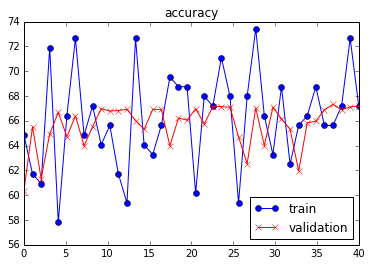

In [20]:
#set of a tf graph

num_nodes= 1024
batch_size = 128
input_size=X.shape[1]#dimension of each input vector
num_labels=2

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                      shape=(batch_size, input_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    weights_1 = tf.Variable(
      tf.truncated_normal([input_size, num_nodes]))
    biases_1 = tf.Variable(tf.zeros([num_nodes]))
    weights_2 = tf.Variable(
      tf.truncated_normal([num_nodes, num_labels]))
    biases_2 = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    relu_layer=tf.nn.relu(tf.matmul(tf_train_dataset, weights_1) + biases_1)#notice the shape of tf_train_dataset and weights_1
    logits = tf.matmul(relu_layer, weights_2) + biases_2
    loss = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(
     tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, weights_1) + biases_1), weights_2) + biases_2)
    test_prediction =  tf.nn.softmax(
     tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, weights_1) + biases_1), weights_2) + biases_2)


num_steps = 40000
train_acc=[]
valid_acc=[]
train_F1=[]
valid_F1=[]
loss_log=[]
    
    
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 1000 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
            valid_prediction.eval(), valid_labels))
            
            print("Minibatch prec,recall,F1: %.3f %.3f %.3f"  % precision_recall(predictions, batch_labels))
            print("validation prec,recall,F1: %.3f %.3f %.3f" % precision_recall(
            valid_prediction.eval(), valid_labels))
            
            
            loss_log.append(l)
            train_acc.append(accuracy(predictions, batch_labels))
            valid_acc.append(accuracy(
            valid_prediction.eval(), valid_labels))
            train_F1.append(precision_recall(predictions, batch_labels))
            valid_F1.append(precision_recall(
            valid_prediction.eval(), valid_labels))
            print("===================")
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
    print("Test accuracy: %.3f %.3f %.3f" % precision_recall(test_prediction.eval(), test_labels))
plot_tf(train_acc,valid_acc)
plt.title('accuracy')

In [ ]:
#https://www.coursera.org/learn/machine-learning/lecture/9zJUs/mini-batch-gradient-descent

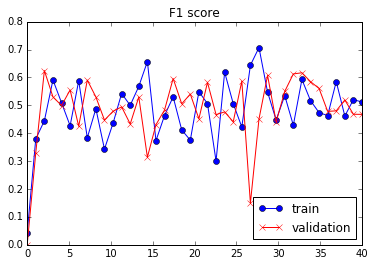

In [22]:
#plot F1 scores
f1t=[i[2] for i in train_F1]
f1v=[i[2] for i in valid_F1]
plot_tf(f1t,f1v)
plt.title('F1 score')


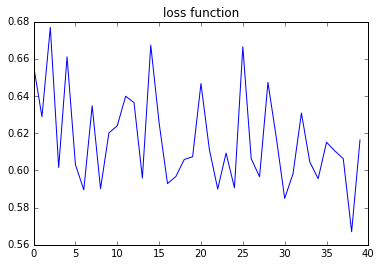

In [23]:

plt.plot(loss_log)
plt.title('loss function')

<h1 style='background:blue;color:white;'>USE A DATASET WITH MORE complete FEATURES (13)</h1>


### AND TRY TO GET SOME ERROR CASES

In [161]:
#EXAMPLE: Celebration,celebration,nn,1,4,0,0,0,0,0,0,0,0,0,0.0909090909091,0.00163132137031,1
#pipeline
#load data with no header and no nominal attributes
#datafile='Data/singleton_data_mini.tab'
#X,labels = load_data(datafile,header=False)

#load new data with header row and nominal attributes in the first 3 cols
datafile='Data/singleton_data_new.tab'
X,labels = load_data(datafile)

#shuffle dataset
dataset_shf,labels_shf = randomize(X, labels)

(350845, 13)


In [162]:
dataset_shf.shape

(350845, 13)

In [165]:
#sample sgt and non-sgt data
ind_notsgt,ind_sgt=get_singleton(labels_shf)
singleton_data=dataset_shf[ind_sgt]
notsgt_data=dataset_shf[ind_notsgt]
singleton_labels=labels_shf[ind_sgt]
notsgt_labels=labels_shf[ind_notsgt]
#print (len(notsgt_data)+len(singleton_data)==len(labels_shf))
print ("non-singleton,singleton in the original dataset:", len(notsgt_data),len(singleton_data))



#construct the entire undersampled dataset
import random
num_notsgt_samples=100000
notsgt_inds=random.sample(xrange(len(notsgt_data)),num_notsgt_samples)
undersampled_notsgt=notsgt_data[notsgt_inds]
undersampled_notsgt_labels=notsgt_labels[notsgt_inds]
#construct the whole data set
undersampled_data=np.concatenate((undersampled_notsgt,singleton_data), axis=0)
undersampled_labels=np.concatenate((undersampled_notsgt_labels,singleton_labels), axis=0)
#construct the whole labels
#undersampled_notsgt_labels=
print ("final undersampled data set size:",len(undersampled_data))




#divide train, valid, test
dataset_shf_und,labels_shf_und = randomize(undersampled_data, undersampled_labels)
train_size=int(len(undersampled_data)*0.9)
val_size=int(len(undersampled_data)*0.05)
test_isze=int(len(undersampled_data)*0.05)
#get sizes of division
train_dataset=dataset_shf_und[:int(train_size),:]
valid_dataset=dataset_shf_und[int(train_size):int(train_size+val_size),:]
test_dataset=dataset_shf_und[int(train_size+val_size):,:]
train_labels=labels_shf_und[:int(train_size)]
valid_labels=labels_shf_und[int(train_size):int(train_size+val_size)]
test_labels=labels_shf_und[int(train_size+val_size):]
#divide the dataset
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)
print (train_dataset.shape)

non-singleton,singleton in the original dataset: 284276 66569
final undersampled data set size: 166569
(149912, 13)


In [166]:
#set of a tf graph
def main(num_nodes= 1024,batch_size = 128,num_steps = 10000,report_step=250):
    
    input_size=X.shape[1]#dimension of each input vector
    print('================num_nodes_hidden,batch_size:',num_nodes,batch_size)
    print('================input_feature_size:',input_size)
    num_labels=2

    graph = tf.Graph()
    with graph.as_default():

        # Input data. For the training data, we use a placeholder that will be fed
        # at run time with a training minibatch.
        tf_train_dataset = tf.placeholder(tf.float32,
                                          shape=(batch_size, input_size))
        tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
        tf_valid_dataset = tf.constant(valid_dataset)
        tf_test_dataset = tf.constant(test_dataset)

        # Variables.
        weights_1 = tf.Variable(
          tf.truncated_normal([input_size, num_nodes]))
        biases_1 = tf.Variable(tf.zeros([num_nodes]))
        weights_2 = tf.Variable(
          tf.truncated_normal([num_nodes, num_labels]))
        biases_2 = tf.Variable(tf.zeros([num_labels]))

        # Training computation.
        relu_layer=tf.nn.relu(tf.matmul(tf_train_dataset, weights_1) + biases_1)#notice the shape of tf_train_dataset and weights_1
        logits = tf.matmul(relu_layer, weights_2) + biases_2
        loss = tf.reduce_mean(
          tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

        # Optimizer.
        optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(loss)

        # Predictions for the training, validation, and test data.
        train_prediction = tf.nn.softmax(logits)
        valid_prediction = tf.nn.softmax(
         tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, weights_1) + biases_1), weights_2) + biases_2)
        test_prediction =  tf.nn.softmax(
         tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, weights_1) + biases_1), weights_2) + biases_2)


    
    print ('=================num steps:',num_steps)
    train_acc=[]
    valid_acc=[]
    train_F1=[]
    valid_F1=[]
    loss_log=[]



    with tf.Session(graph=graph) as session:
        tf.initialize_all_variables().run()
        print("Initialized")
        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
            _, l, predictions = session.run(
              [optimizer, loss, train_prediction], feed_dict=feed_dict)
            if (step % report_step == 0):
                #print("Minibatch loss at step %d: %f" % (step, l))
                #print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
                #print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))

                #print("Minibatch prec,recall,F1: %.3f %.3f %.3f"  % precision_recall(predictions, batch_labels))
                #print("validation prec,recall,F1: %.3f %.3f %.3f" % precision_recall(valid_prediction.eval(), valid_labels))


                loss_log.append(l)
                train_acc.append(accuracy(predictions, batch_labels))
                valid_acc.append(accuracy(valid_prediction.eval(), valid_labels))
                train_F1.append(precision_recall(predictions, batch_labels))
                valid_F1.append(precision_recall(valid_prediction.eval(), valid_labels))

                #print("===================")
        print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
        print("Test precision, recall, F1: %.3f %.3f %.3f" % precision_recall(test_prediction.eval(), test_labels))
    plt.figure(0)
    plot_tf(train_acc,valid_acc)
    plt.title('accuracy')
    #plot F1 scores
    f1t=[i[2] for i in train_F1]
    f1v=[i[2] for i in valid_F1]
    plt.figure(1)
    plot_tf(f1t,f1v)
    plt.title('F1 score')
    
    #plot precision
    prect=[i[0] for i in train_F1]
    precv=[i[0] for i in valid_F1]
    plt.figure(2)
    plot_tf(prect,precv)
    plt.title('Precision')

    #plot losss
    plt.figure(3)
    plt.plot(loss_log)
    plt.title('loss function')
    return train_F1,valid_F1,loss_log

<span style='background:yellow; font-size:14pt;'>RUN:new_data_1013_1<span>

================num_nodes_hidden,batch_size: 1024 128
================input_feature_size: 13
=================num steps: 40000
Initialized
Test accuracy: 71.1%
Test precision, recall, F1: 0.673 0.557 0.609


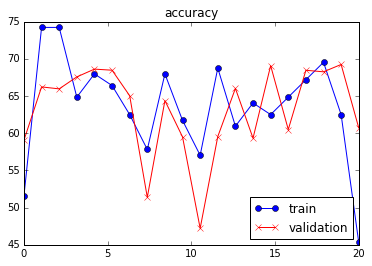

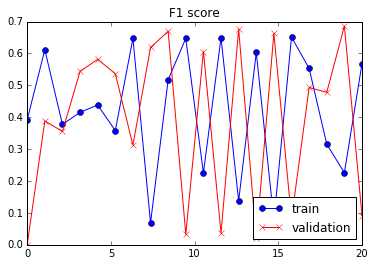

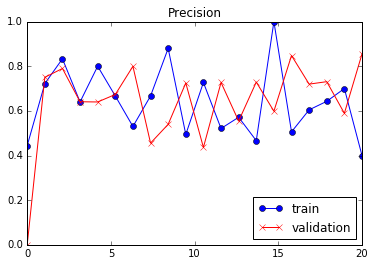

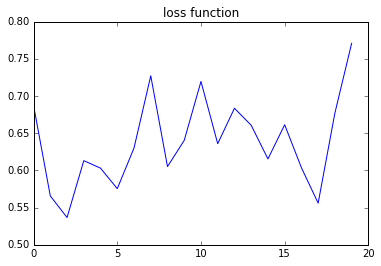

In [297]:
t,v,l=main(1024,128,40000,2000)

<span style='background:yellow; font-size:14pt;'>RUN:new_data_1013_2<span>

================num_nodes_hidden,batch_size: 1024 128
================input_feature_size: 13
=================num steps: 20000
Initialized
Test accuracy: 69.0%
Test precision, recall, F1: 0.706 0.399 0.510


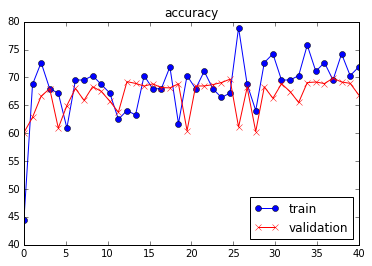

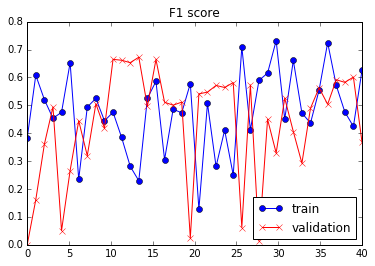

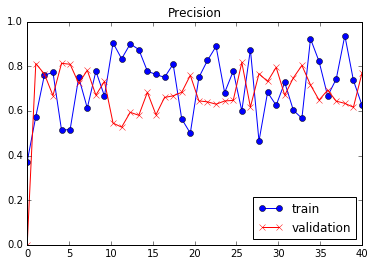

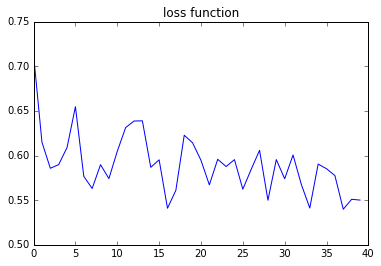

In [170]:
t,v,l=main(1024,128,20000,500)

<span style='background:yellow; font-size:14pt;'>RUN:new_data_1013_3<span>

================num_nodes_hidden,batch_size: 1024 128
================input_feature_size: 13
=================num steps: 30000
Initialized
Test accuracy: 69.0%
Test precision, recall, F1: 0.593 0.736 0.657


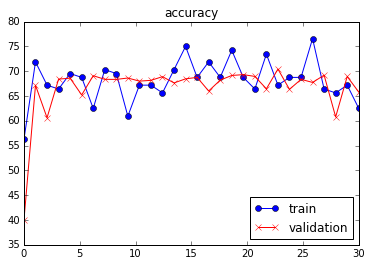

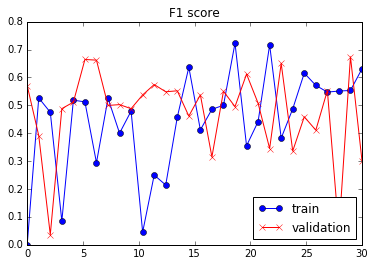

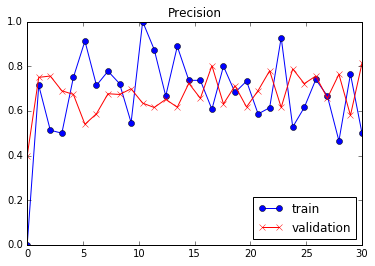

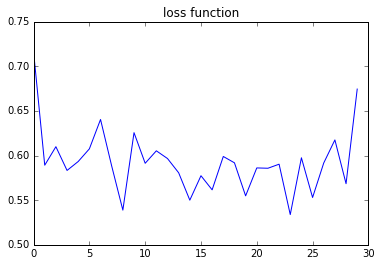

In [171]:
train,valid,loss=main(1024,128,30000,1000)

<span style='background:yellow; font-size:14pt;'>RUN:new_data_1013_4<span>

================num_nodes_hidden,batch_size: 1024 128
================input_feature_size: 13
=================num steps: 5000
Initialized
Test accuracy: 65.7%
Test precision, recall, F1: 0.807 0.196 0.315


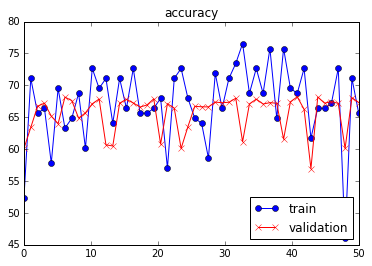

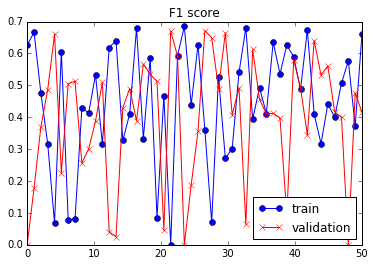

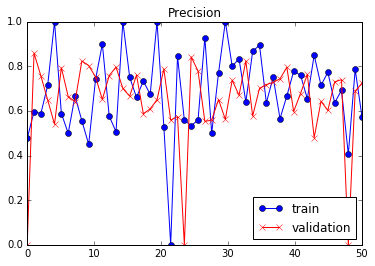

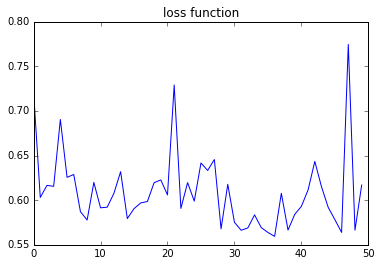

In [173]:
train,valid,loss=main(1024,128,5000,100)

<span style='background:yellow; font-size:14pt;'>RUN:new_data_1013_5<span>

================num_nodes_hidden,batch_size: 10 128
================input_feature_size: 13
=================num steps: 20000
Initialized
Test accuracy: 66.3%
Test precision, recall, F1: 0.668 0.324 0.436


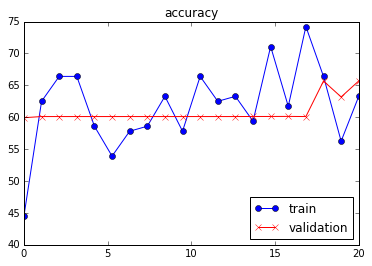

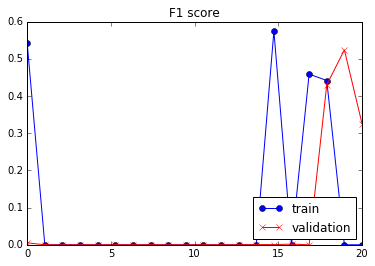

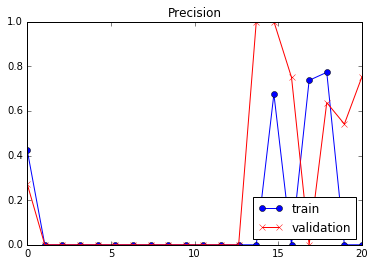

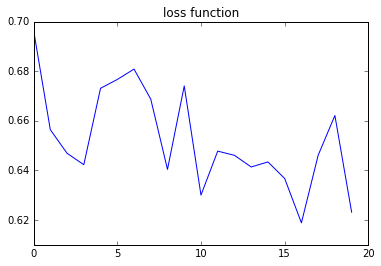

In [175]:
t,v,l=main(10,128,20000,1000)

<span style='background:yellow; font-size:14pt;'>RUN:new_data_1013_6<span>

================num_nodes_hidden,batch_size: 256 128
================input_feature_size: 13
=================num steps: 20000
Initialized
Test accuracy: 66.9%
Test precision, recall, F1: 0.663 0.365 0.471


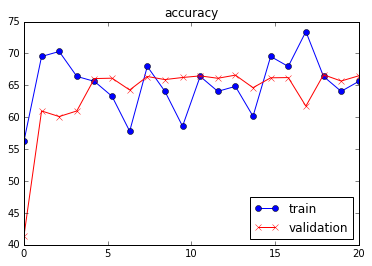

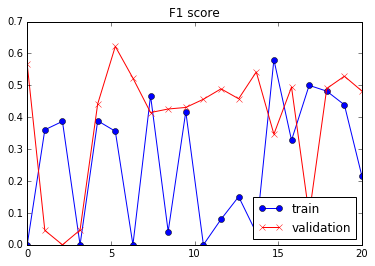

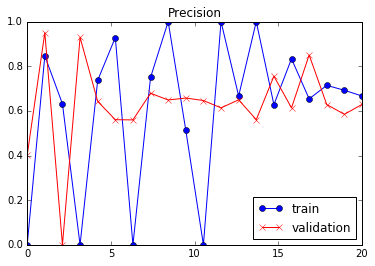

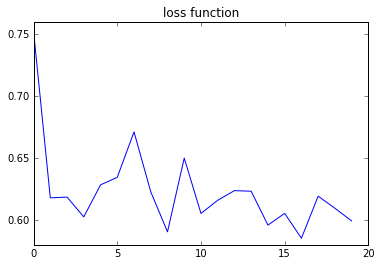

In [183]:
t,v,l=main(256,128,20000,1000)

## retrieve the error cases

In [185]:
predicted_sgt=np.sum(np.argmax(predictions,1)==0)

In [188]:
predictions[:10]

array([[ 0.37080285,  0.62919712],
       [ 0.38562655,  0.61437345],
       [ 0.42572922,  0.57427078],
       [ 0.30796358,  0.69203639],
       [ 0.64926642,  0.35073352],
       [ 0.34920087,  0.6507991 ],
       [ 0.61010295,  0.38989702],
       [ 0.46599802,  0.53400195],
       [ 0.34212729,  0.65787274],
       [ 0.25874332,  0.74125671]], dtype=float32)

In [189]:
labels[:10]

array([[ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.]], dtype=float32)

In [208]:
def get_error_cases(predictions,labels):
    false_sgt=[]
    false_nsgt=[]
    for i in range(len(predictions)):
            if np.argmax(predictions[i]) == 0 and  np.argmax(labels[i]) == 1:
                false_sgt.append(i)
            elif np.argmax(predictions[i]) == 1 and  np.argmax(labels[i]) == 0:
                false_nsgt.append(i)
    return false_sgt,false_nsgt

In [201]:
p=np.array([1,2,3,4,5])
p=p+1

In [202]:
p

array([2, 3, 4, 5, 6])

In [277]:
#set of a tf graph
def run_tf_noplot(num_nodes= 1024,batch_size = 128,num_steps = 10000,report_step=250):
    
    input_size=X.shape[1]#dimension of each input vector
    print('================num_nodes_hidden,batch_size:',num_nodes,batch_size)
    print('================input_feature_size:',input_size)
    num_labels=2

    graph = tf.Graph()
    with graph.as_default():

        # Input data. For the training data, we use a placeholder that will be fed
        # at run time with a training minibatch.
        tf_train_dataset = tf.placeholder(tf.float32,
                                          shape=(batch_size, input_size))
        tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
        tf_valid_dataset = tf.constant(valid_dataset)
        tf_test_dataset = tf.constant(test_dataset)

        # Variables.
        weights_1 = tf.Variable(
          tf.truncated_normal([input_size, num_nodes]))
        biases_1 = tf.Variable(tf.zeros([num_nodes]))
        weights_2 = tf.Variable(
          tf.truncated_normal([num_nodes, num_labels]))
        biases_2 = tf.Variable(tf.zeros([num_labels]))

        # Training computation.
        relu_layer=tf.nn.relu(tf.matmul(tf_train_dataset, weights_1) + biases_1)
        #notice the shape of tf_train_dataset and weights_1
        logits = tf.matmul(relu_layer, weights_2) + biases_2
        loss = tf.reduce_mean(
          tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

        # Optimizer.
        optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(loss)

        # Predictions for the training, validation, and test data.
        train_prediction = tf.nn.softmax(logits)
        valid_prediction = tf.nn.softmax(
         tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, weights_1) + biases_1), weights_2) + biases_2)
        test_prediction =  tf.nn.softmax(
         tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, weights_1) + biases_1), weights_2) + biases_2)


    
    print ('=================num steps:',num_steps)
    train_acc=[]
    valid_acc=[]
    train_F1=[]
    valid_F1=[]
    loss_log=[]
    false_sgt_log=[]
    false_nsgt_log=[]



    with tf.Session(graph=graph) as session:
        tf.initialize_all_variables().run()
        print("Initialized")
        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
            if (step % report_step == 0):
                #print("Minibatch loss at step %d: %f" % (step, l))
                #print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
                #print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))

                #print("Minibatch prec,recall,F1: %.3f %.3f %.3f"  % precision_recall(predictions, batch_labels))
                #print("validation prec,recall,F1: %.3f %.3f %.3f" % precision_recall(valid_prediction.eval(), valid_labels))

                #get some error cases in training (not yet validation errors)
                #print (predictions)
                #print (batch_labels)
                false_sgt,false_nsgt=get_error_cases(predictions,batch_labels)
                #print('false_sgt:',false_sgt)
                #print('false_nsgt:',false_nsgt)
                false_sgt_batch=offset+np.array(false_sgt)
                false_nsgt_batch=offset+np.array(false_nsgt)
                false_sgt_log.append(false_sgt_batch)
                false_nsgt_log.append(false_nsgt_batch)
                #print ('offset:',offset)
                #print (false_sgt_log)

                loss_log.append(l)
                train_acc.append(accuracy(predictions, batch_labels))
                valid_acc.append(accuracy(valid_prediction.eval(), valid_labels))
                train_F1.append(precision_recall(predictions, batch_labels))
                valid_F1.append(precision_recall(valid_prediction.eval(), valid_labels))

                #print("===================")
        print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
        print("Test precision, recall, F1: %.3f %.3f %.3f" % precision_recall(test_prediction.eval(), test_labels))
    
    return train_F1,valid_F1,loss_log, false_sgt_log,false_nsgt_log

In [ ]:
#now, you can return the false ones at each report step, but they are not meaningful yet. You 
#probably do something such as return the mistakes on validation and test, or the last of train
# or something

In [227]:
t,v,l,fs,fns=run_tf(10,128,1000,50)

================num_nodes_hidden,batch_size: 10 128
================input_feature_size: 13
=================num steps: 1000
Initialized
false_sgt: []
false_nsgt: [2, 4, 6, 13, 14, 23, 25, 30, 31, 33, 34, 41, 42, 47, 49, 52, 53, 55, 63, 64, 67, 68, 69, 72, 73, 74, 75, 78, 80, 82, 87, 88, 89, 90, 91, 92, 96, 97, 99, 100, 104, 107, 108, 113, 114, 115, 116, 117, 118, 119, 121, 122, 123, 124, 126, 127]
offset: 0
false_sgt: []
false_nsgt: [1, 2, 3, 7, 8, 9, 18, 23, 25, 29, 35, 36, 37, 38, 43, 44, 49, 50, 51, 53, 54, 55, 56, 59, 60, 61, 63, 65, 66, 69, 72, 73, 74, 76, 81, 82, 83, 84, 87, 88, 96, 99, 101, 105, 107, 118, 120, 123, 125]
offset: 6400
false_sgt: []
false_nsgt: [0, 2, 4, 5, 9, 11, 12, 16, 18, 19, 22, 26, 28, 29, 30, 31, 32, 35, 37, 39, 40, 41, 44, 47, 50, 53, 56, 59, 63, 65, 66, 67, 70, 76, 81, 84, 89, 91, 97, 100, 104, 106, 108, 109, 112, 113, 117, 119, 125]
offset: 12800
false_sgt: []
false_nsgt: [0, 3, 5, 6, 8, 9, 10, 11, 13, 15, 16, 18, 19, 23, 29, 34, 35, 36, 39, 40, 51, 52, 5

## try to add an original index in order to access the error lines in the original data to see lemma, etc. 

In [261]:
def load_nominal(datafile):
    output=[]
    f=open(datafile,'r').read().split('\n')
    
    for line in f[1:]:
        end_nominal=get_num_features(line)
        output.append(line[:end_nominal])
    
    return np.array(output)

In [262]:
nominals=load_nominal(datafile)

In [235]:
def load_data(datafile,header=True):
    if header==True:
        data = np.loadtxt(strip_first_col(datafile),skiprows=1,delimiter=',')
    else:
        data = np.loadtxt(datafile, delimiter=',',skiprows=1)

    # first ten values are the one hot encoded y (target) values
    y = data[:, -1]
    
    data = data[:, :-1]  # x data
    # data = data - data.mean(axis = 1)
    data -= data.min()  # scale the data so values are between 0 and 1
    data /= data.max()  # scale
    out = []
    labels=[]
    print(data.shape)
    label_dict={1:[0,1],0:[1,0]}
    # populate the tuple list with the data
    
    for i in range(data.shape[0]):
        
        fart = list((data[i, :].tolist()))  # don't mind this variable name
        out.append(fart)
        #two classes one hot coding:two classes are [NS,S] y=1:[0,1]; y=0:[1,0]
        labels.append(label_dict[y[i]])

    return np.array(out,dtype=np.float32),np.array(labels,dtype=np.float32)


len(dataset_shf)

350845

In [234]:
X.shape[0]

350845

In [236]:
dataset_shf[0]

array([ 0.00497512,  0.01492537,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.00480929,  0.00353106], dtype=float32)

In [260]:
datafile='Data/singleton_data_new.tab'
X,labels = load_data(datafile)
dataset_shf,labels_shf = randomize(X, labels)


(350845, 13)


In [264]:
def randomize(dataset, labels,nominals):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:]
    shuffled_labels = labels[permutation]
    shuffled_nominals = nominals[permutation]
    return shuffled_dataset, shuffled_labels, shuffled_nominals




In [265]:
datafile='Data/singleton_data_new.tab'
X,labels = load_data(datafile)
nominals=load_nominal(datafile)
#shuffle dataset
dataset_shf,labels_shf, nominal_shf = randomize(X, labels, nominals)



#sample sgt and non-sgt data
ind_notsgt,ind_sgt=get_singleton(labels_shf)
singleton_data=dataset_shf[ind_sgt]
notsgt_data=dataset_shf[ind_notsgt]
singleton_labels=labels_shf[ind_sgt]
notsgt_labels=labels_shf[ind_notsgt]
singleton_nominal=nominal_shf[ind_sgt]
notsgt_nominal=nominal_shf[ind_notsgt]

#print (len(notsgt_data)+len(singleton_data)==len(labels_shf))
print ("non-singleton,singleton in the original dataset:", len(notsgt_data),len(singleton_data))



#construct the entire undersampled dataset
import random
num_notsgt_samples=100000
notsgt_inds=random.sample(xrange(len(notsgt_data)),num_notsgt_samples)
undersampled_notsgt=notsgt_data[notsgt_inds]
undersampled_notsgt_labels=notsgt_labels[notsgt_inds]
undersampled_notsgt_nominal=notsgt_nominal[notsgt_inds]

#construct the whole data set
undersampled_data=np.concatenate((undersampled_notsgt,singleton_data), axis=0)
undersampled_labels=np.concatenate((undersampled_notsgt_labels,singleton_labels), axis=0)
undersampled_nominal=np.concatenate((undersampled_notsgt_nominal,singleton_nominal), axis=0)

#construct the whole labels
#undersampled_notsgt_labels=
print ("final undersampled data set size:",len(undersampled_data))




#divide train, valid, test
dataset_shf_und,labels_shf_und,nominal_shf_und = randomize(undersampled_data, undersampled_labels,undersampled_nominal)
train_size=int(len(undersampled_data)*0.9)
val_size=int(len(undersampled_data)*0.05)
test_isze=int(len(undersampled_data)*0.05)
#get sizes of division
train_dataset=dataset_shf_und[:int(train_size),:]
valid_dataset=dataset_shf_und[int(train_size):int(train_size+val_size),:]
test_dataset=dataset_shf_und[int(train_size+val_size):,:]
train_labels=labels_shf_und[:int(train_size)]
valid_labels=labels_shf_und[int(train_size):int(train_size+val_size)]
test_labels=labels_shf_und[int(train_size+val_size):]
train_nominal=nominal_shf_und[:int(train_size)]
valid_nominal=nominal_shf_und[int(train_size):int(train_size+val_size)]
test_nominal=nominal_shf_und[int(train_size+val_size):]


#divide the dataset
train_dataset, train_labels, train_nominal = randomize(train_dataset, train_labels, train_nominal)
test_dataset, test_labels, test_nominal = randomize(test_dataset, test_labels, test_nominal)
valid_dataset, valid_labels, valid_nominal = randomize(valid_dataset, valid_labels, valid_nominal)
print (train_dataset.shape)



(350845, 13)
non-singleton,singleton in the original dataset: 284276 66569
final undersampled data set size: 166569
(149912, 13)


# after setting up nominals, we can obtain what is the error cases at the last iteration of the training (notice I called a variant of run_tf_noplot, where there is no plotting) 

In [271]:
t,v,l,fs,fns=run_tf_noplot(1024,128,20000,100)

================num_nodes_hidden,batch_size: 1024 128
================input_feature_size: 13
=================num steps: 20000
Initialized
Test accuracy: 66.6%
Test precision, recall, F1: 0.807 0.231 0.360


In [272]:
fs[-1]

array([911, 970])

In [273]:
fns[-1]

array([879, 881, 883, 895, 901, 903, 904, 905, 906, 908, 915, 923, 926,
       931, 938, 942, 943, 944, 945, 949, 950, 952, 955, 957, 958, 962,
       965, 971, 979, 980, 983, 984, 985, 986, 987, 997])

In [276]:
print (train_nominal[fns[-1]])

['no sin,sin,nsubj' 'the future of Jerusalem,future,dobj'
 'Television,television,nsubj' 'customers,customer,dobj'
 'the contracts it had sold earlier for December delivery in London,contract,pobj'
 'the court,court,pobj' 'and the mercy of God and His blessings,mercy,dep'
 'the skies and the earth that we have now,sky,dobj'
 'about 1/20 percentage point,point,npadvmod' "Spain 's,spain,poss"
 'one month,month,npadvmod' 'the suit,suit,dobj'
 'the king of the Jews,king,dobj'
 "the cause of Saturday 's crash of a Honduran jetliner that killed 132 of the 146 people aboard,cause,pobj"
 'Erich,erich,nn' 'packaging products,product,pobj' 'death,death,pobj'
 'the Chinese New Year,year,pobj' 'the people,people,pobj' 'Mr.,mr.,nn'
 'an annual `` A Christmas Carol,carol,dobj'
 'the overall standard of this competition,standard,nsubj'
 'everyone,everyone,dobj' 'studios,studio,nsubj' 'China,china,pobj'
 'the economy,economy,nsubjpass' 'the common people,people,pobj'
 'the people,people,nsubj' 'Mr.,mr

In [278]:
print (train_nominal[fs[-1]])

['Taipei,taipei,nn' 'detainees,detainee,pobj']


In [283]:
X

array([[  9.95024852e-03,   4.97512426e-03,   4.97512426e-03, ...,
          0.00000000e+00,   9.04568064e-04,   1.62320539e-05],
       [  4.97512426e-03,   9.95024852e-03,   0.00000000e+00, ...,
          0.00000000e+00,   1.80913613e-03,   3.24641078e-05],
       [  9.95024852e-03,   1.49253728e-02,   0.00000000e+00, ...,
          0.00000000e+00,   3.16598825e-03,   5.68121868e-05],
       ..., 
       [  4.47761193e-02,   1.49253728e-02,   4.97512426e-03, ...,
          4.97512426e-03,   1.16086239e-03,   4.87489300e-03],
       [  1.49253728e-02,   1.49253728e-02,   0.00000000e+00, ...,
          4.97512426e-03,   1.82421226e-03,   4.89311665e-03],
       [  4.97512426e-03,   1.49253728e-02,   0.00000000e+00, ...,
          0.00000000e+00,   2.32172478e-03,   4.90678474e-03]], dtype=float32)

In [284]:
np.save("singleton_new.npy", X)

In [287]:
np.save("singleton_new_labels.npy",labels)

In [286]:
labels.shape

(350845, 2)

In [288]:
outfile="singleton_new.npy"
new_X=np.load(outfile)

In [290]:
new_X==X


array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ..., 
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]], dtype=bool)

In [292]:

import os.path
os.path.isfile('Data/singleton_new.npy')

False